# Electric Field & GIC Geographic Analysis

This notebook demonstrates the complete GIC workflow on a geographic coordinate
system: building a 2D electric field grid over the case's footprint, computing
spatially-varying E-fields, overlaying them on the transmission network,
running GIC calculations, and exporting the field to PowerWorld's B3D format.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from esapp import GridWorkBench
from esapp.components import Branch, Bus, Substation, GICXFormer
from esapp.utils import (
    Grid2D, B3D,
    format_plot, plot_vecfield, plot_lines,
    border, darker_hsv_colormap,
)

In [2]:
# This cell is hidden in the documentation.
import ast

with open('../data/case_B.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

wb = GridWorkBench(case_path)

# Configure geographic border shape ('US', 'Texas', etc.)
SHAPE = 'Texas'

'open' took: 3.8419 sec


In [3]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import (
    plot_geo_grid_buses, plot_efield_comparison, plot_efield_vectors,
    plot_network_efield, plot_barh_top, plot_gic_geo_map,
    plot_direction_sensitivity, plot_b3d_roundtrip,
)

Import the case and instantiate the `GridWorkBench`.

```python
from esapp import GridWorkBench
wb = GridWorkBench(case_path)
```

## Extracting Geographic Extent

We extract bus coordinates from the case and determine the geographic bounding box
that will define our E-field computation grid.

In [ ]:
# Get bus coordinates
lon, lat = wb.buscoords()

# Determine geographic bounding box with padding
pad = 0.5 
lon_min, lon_max = lon.min() - pad, lon.max() + pad
lat_min, lat_max = lat.min() - pad, lat.max() + pad

## 2. Building a Geographic E-Field Grid

We construct a 2D grid in latitude/longitude space covering the case's geographic
footprint. Each grid point will hold Ex and Ey components of the electric field in V/km.

In [ ]:
# Grid resolution
nx, ny = 40, 30

# Coordinate arrays
lons = np.linspace(lon_min, lon_max, nx)
lats = np.linspace(lat_min, lat_max, ny)
LON, LAT = np.meshgrid(lons, lats)

# Grid2D for finite difference operators if needed
grid = Grid2D((nx, ny))

Grid: 40 x 30 = 1200 points
Edges: 2330 (horizontal: 1170, vertical: 1160)
Resolution: 0.281 deg lon x 0.364 deg lat


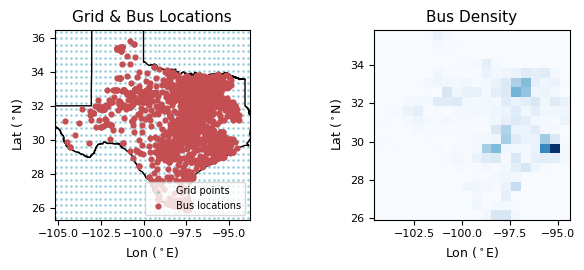

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.8))
plot_geo_grid_buses(LON, LAT, lon, lat, SHAPE,
                    xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
                    ax=axes[0], fig=fig)
# Bus coordinate density
axes[1].hist2d(lon, lat, bins=20, cmap='Blues')
format_plot(axes[1], title='Bus Density',
            xlabel=r'Lon ($^\circ$E)', ylabel=r'Lat ($^\circ$N)',
            plotarea='white', grid=False, titlesize=11, labelsize=9, ticksize=8)
axes[1].set_aspect('equal')
plt.tight_layout()
plt.show()

## 3. Defining Electric Fields

We define several E-field patterns on the geographic grid. A **uniform field**
with constant magnitude and direction serves as a baseline. A **spatially
varying field** whose magnitude increases with latitude models conductivity
variation. A **rotational field** whose direction varies with longitude
demonstrates non-uniform storm geometry.

In [7]:
E_mag = 1.0  # V/km
E_dir = 90.0  # degrees from North (90 = East)

Ex_uniform = E_mag * np.sin(np.radians(E_dir)) * np.ones_like(LON)
Ey_uniform = E_mag * np.cos(np.radians(E_dir)) * np.ones_like(LON)

In [8]:
# Latitude-dependent magnitude: stronger in the north
E_magnitude = 0.5 + 1.5 * (LAT - lat_min) / (lat_max - lat_min)  # 0.5 to 2.0 V/km

Ex_varying = E_magnitude * np.sin(np.radians(E_dir))
Ey_varying = E_magnitude * np.cos(np.radians(E_dir))

# Rotational field: direction varies with longitude
lon_center = (lon_min + lon_max) / 2
angle_field = np.pi / 2 + 0.5 * np.pi * (LON - lon_center) / (lon_max - lon_center)

Ex_rotational = E_mag * np.cos(angle_field)
Ey_rotational = E_mag * np.sin(angle_field)

## E-Field Visualization Gallery

We demonstrate multiple visualization styles for the electric fields overlaid on geographic features.

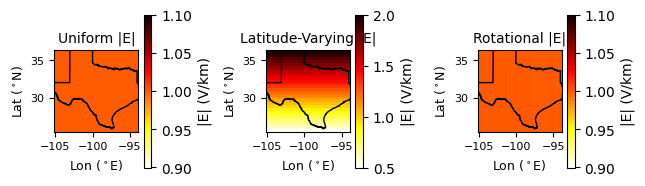

In [9]:
fields = [
    ('Uniform', Ex_uniform, Ey_uniform),
    ('Latitude-Varying', Ex_varying, Ey_varying),
    ('Rotational', Ex_rotational, Ey_rotational),
]

plot_efield_comparison(LON, LAT, fields, SHAPE)

### E-Field with Transmission Network Overlay

Combine the E-field visualization with the actual transmission network from the PowerWorld case.

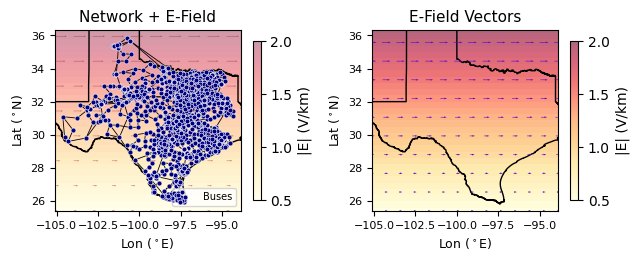

In [10]:
lines = wb[Branch, ['Longitude', 'Longitude:1', 'Latitude', 'Latitude:1']]
magnitude = np.sqrt(Ex_varying**2 + Ey_varying**2)

fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.8))
plot_network_efield(LON, LAT, magnitude, lines, lon, lat,
                    Ex_varying, Ey_varying, SHAPE, ax=axes[0], fig=fig)
plot_efield_vectors(LON, LAT, Ex_varying, Ey_varying, SHAPE,
                    ax=axes[1], fig=fig)
plt.tight_layout()
plt.show()

## 5. Computing GIC from the E-Field

With the GIC model built from `wb.gic.model()`, we compute transformer
GICs. The storm function applies a uniform E-field and PowerWorld
computes the resulting neutral currents in each transformer.

In [11]:
wb.gic.configure()
wb.gic.model() # Cosntructs GIC Model

# Uniform storm via PowerWorld (baseline)
wb.gic.storm(1.0, 90)
gic_data = wb[GICXFormer, ['BusNum3W', 'BusNum3W:1', 'GICXFNeutralAmps']]

# Top 10 transformers by GIC magnitude
top10 = gic_data.reindex(gic_data['GICXFNeutralAmps'].abs().sort_values(ascending=False).index).head(10)
print(top10.to_string(index=False))

 BusNum3W  BusNum3W:1  BusNum3W:2  BusNum3W:5  GICXFNeutralAmps LineCircuit
     1079        1071           0        1071       -122.993401           1
     7073        7074           0        7074        107.543900           1
     4146        4147           0        4147        -98.133308           1
     7047        7048           0        7048        -96.076111           1
     5045        5046           0        5046         90.701279           1
     6234        6235           0        6235        -90.185265           1
     5451        5452           0        5452        -86.951988           1
     5204        5205           0        5205        -84.667992           1
     6308        6309           0        6309        -75.916336           1
     5192        5193           0        5193        -64.725769           1


## GIC Results on the Geographic Map

Overlay GIC magnitudes on the transmission network map. Transformer locations are
plotted with marker size proportional to GIC magnitude.

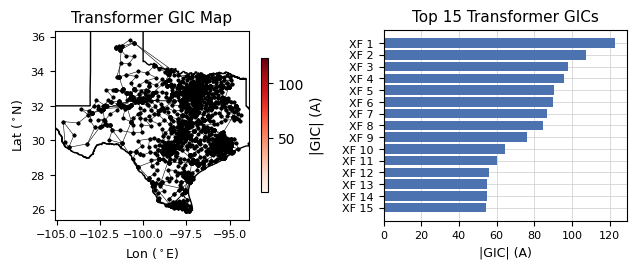

In [12]:
bus_coords = wb[Bus, ['BusNum', 'Longitude', 'Latitude']]
xf_geo = gic_data.merge(bus_coords, left_on='BusNum3W', right_on='BusNum', how='inner')
gic_mag = xf_geo['GICXFNeutralAmps'].abs()

fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.8))
plot_gic_geo_map(lines, xf_geo, gic_mag, SHAPE,
                 xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
                 ax=axes[0], fig=fig)
# Top transformer GICs
top = gic_mag.sort_values(ascending=False).head(15)
axes[1].barh(range(len(top)), top.values, color='#4C72B0')
axes[1].set_yticks(range(len(top)))
axes[1].set_yticklabels([f'XF {i+1}' for i in range(len(top))], fontsize=7)
axes[1].invert_yaxis()
format_plot(axes[1], title='Top 15 Transformer GICs',
            xlabel='|GIC| (A)', plotarea='white',
            titlesize=11, labelsize=9, ticksize=8)
plt.tight_layout()
plt.show()

## 7. Storm Direction Sensitivity

Sweep the E-field direction from 0 to 360 degrees and track the maximum GIC
at each direction. This reveals which storm orientations produce the worst-case
GIC for this network.

In [13]:
directions = np.arange(0, 361, 10)
max_gics = []

for d in directions:
    wb.gic.storm(1.0, d)
    gic_vals = wb[GICXFormer, 'GICXFNeutralAmps']['GICXFNeutralAmps']
    max_gics.append(gic_vals.abs().max())

max_gics = np.array(max_gics)

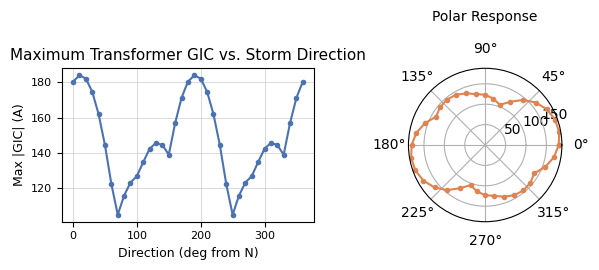

Worst-case direction: 10 degrees
Worst-case max GIC: 184.07 Amps


In [14]:
plot_direction_sensitivity(directions, max_gics,
                           title='Maximum Transformer GIC vs. Storm Direction')

## Summary

This notebook demonstrated the full GIC geographic analysis workflow, from
extracting the geographic extent to constructing E-field patterns, visualizing
them with network overlays, computing GIC from spatially-varying fields,
identifying worst-case storm directions, and exporting custom fields to B3D
format for PowerWorld import.